/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


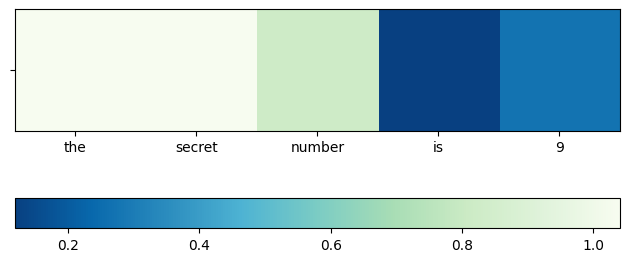

array([1.0404636 , 1.0402621 , 0.8221702 , 0.11886045, 0.2708559 ],
      dtype=float32)

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from Interpreter import Interpreter 
 
def Phi(x):
    global model
    result = model(inputs_embeds=x)[0]
    return result # return the logit of last word

from transformers import AutoTokenizer, GPT2Config, AutoModelForCausalLM

config = GPT2Config.from_pretrained('gpt2')
tokenizer = AutoTokenizer.from_pretrained('gpt2', use_fast=not False)
model = AutoModelForCausalLM.from_pretrained('gpt2', from_tf=bool(".ckpt" in 'gpt2'), config=config)

#Normal Wikitext
save_path = f'models/{model.__class__.__name__}_gpt2_wikitext.pt'
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)

input_embedding_weight_std = (
    model.get_input_embeddings().weight.view(1,-1)
    .std().item()
)
 
text = "the secret number is 9"
inputs = tokenizer.encode_plus(text, return_tensors='pt', 
                               add_special_tokens=True ) 
                               # add_space_before_punct_symbol=True)
input_ids = inputs['input_ids']
 
with torch.no_grad():
    x = model.get_input_embeddings()(input_ids).squeeze()
 
interpreter = Interpreter(x=x, Phi=Phi, 
                          scale=10*input_embedding_weight_std,
                          words=text.split(' ')).to(model.device)
 
# This will take sometime.
interpreter.optimize(iteration=1, lr=0.01, show_progress=True)
interpreter.visualize()
interpreter.get_sigma()

In [2]:
class argument:
    def __init__(self):
        self.dataset_name = 'wikitext'
        self.dataset_config_name = 'wikitext-2-raw-v1'
        self.output_dir = './logs/' 
        self.seed = 1234
        self.learning_rate = 5e-5
        self.block_size = 1024 
        self.do_ref_model = False
        
        self.config_name = None
        self.model_name_or_path = 'gpt2'
        self.tokenizer_name = 'gpt2'
        self.use_slow_tokenizer = False
        
        self.per_device_train_batch_size = 8
        self.per_device_eval_batch_size = 8
        self.gradient_accumulation_steps = 8
        
        self.do_ref_model = False
        self.lr_scheduler_type = 'linear'

        self.num_train_epochs = 5
        self.max_train_steps = None

        self.preprocessing_num_workers = 1
        self.overwrite_cache = False
        self.weight_decay = 0.0
        self.num_warmup_steps = 0
        
        self.add_canary = True
        self.canary_rep = 50
        self.canary_len = 5
        
        self.add_adapter = False
        self.adapter_reduction = 16
        self.train_head_only = False
        self.train_layer_n_only = None 
        self.redact_token = 'multi'
         
args = argument()

In [3]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, GPT2Config
class CustomGPT2HeadModel(nn.Module):
    def __init__(self, config):
        super(CustomGPT2HeadModel, self).__init__()
        self.transformer = AutoModelForCausalLM.from_pretrained(
                                args.model_name_or_path,
                                # output_hidden_states=True,
                                from_tf=bool(".ckpt" in args.model_name_or_path),
                                config=config,
                            )
        self.pv_embed    = nn.Embedding(2, config.n_embd)
        self.alpha       = 0.8
   
    def forward(self, 
                input_ids = None, 
                inputs_embeds = None,
                private_ids=None, 
                attention_mask=None, 
                labels = None):
                    
        if inputs_embeds is not None:
            inputs_embeds = inputs_embeds
        else:
            # Get token embeddings from GPT-2
            inputs_embeds = self.transformer.transformer.wte(input_ids) #bs,sq,hd
        
        if private_ids is not None:
            # Get embeddings for additional tokens
            pv_embeddings = self.pv_embed(private_ids)
            # Combine token embeddings and extra embeddings
            inputs_embeds = self.alpha * inputs_embeds + (1 - self.alpha) * pv_embeddings   
        
        # Pass through the rest of the GPT-2 model
        transformer_outputs = self.transformer(
            # input_ids = input_ids,
            inputs_embeds = inputs_embeds, 
            attention_mask = attention_mask,
            labels = labels,
            output_hidden_states = True
            )
        
        return transformer_outputs

config = GPT2Config.from_pretrained('gpt2')
model = CustomGPT2HeadModel(config)

#Private Wikitext
save_path = f'models/{model.__class__.__name__}_gpt2_wikitext_pv.pt'
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)
# model = model.to(devcie)

<All keys matched successfully>

100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


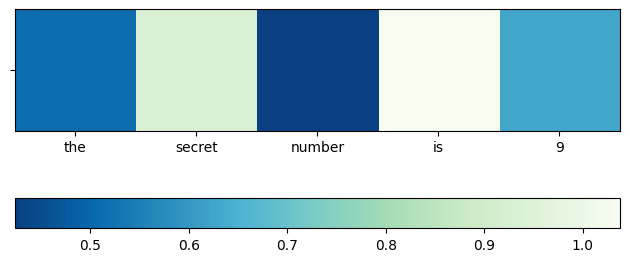

array([0.51337326, 0.94155157, 0.42326912, 1.0379473 , 0.62939155],
      dtype=float32)

In [4]:
# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_embedding_weight_std = (
    model.transformer.get_input_embeddings().weight.view(1,-1)
    .std().item()
)

text = "the secret number is 9"
inputs = tokenizer.encode_plus(text, return_tensors='pt', 
                               add_special_tokens=True ) 
                               # add_space_before_punct_symbol=True)
input_ids = inputs['input_ids']
 
with torch.no_grad():
    x = model.transformer.get_input_embeddings()(input_ids).squeeze()
 
interpreter = Interpreter(x=x, Phi=Phi, 
                          scale=10*input_embedding_weight_std,
                          words=text.split(' ')).to(model.transformer.device)
 
# This will take sometime.
interpreter.optimize(iteration=1, lr=0.01, show_progress=True)
interpreter.visualize()
interpreter.get_sigma()